In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
import pandas as pd
%matplotlib inline

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [149]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def sharpen(img, alpha=30):
    blurred = gaussian_blur(img, 3)
    filter_blurred = gaussian_blur(blurred,1)
    sharpened = blurred + alpha*(blurred-filter_blurred)
    return sharpened
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_locker(get, num_lines = 0):
    pass

def process_lines(lines, testing = False):
    
    """
    Lines in format: [[X-start, Y-start, X-end, Y-end]]
    """
    
    center = image_shape[1]/2
    y_max = image_shape[0]
    
    holder = []
    LHS_lines = []
    RHS_lines = []
    
    for line in lines:
        if (line[0][0] < center) & (line[0][2] < center):
            LHS_lines.append(tuple(line[0]))
        elif (line[0][0] >= center) & (line[0][2] >= center):
            RHS_lines.append (tuple(line[0]))
    
    LHS_lines = np.array(LHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    RHS_lines = np.array(RHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    
    
    n=2
    LHS_lines.sort(order = 'Y1')
    LHS_high = LHS_lines[-n:]
    
    LHS_lines.sort(order = 'Y2')
    LHS_low = LHS_lines[0:n]
    
    RHS_lines.sort(order = 'Y2')
    RHS_high = RHS_lines[-n:]
    RHS_lines.sort(order = 'Y1')
    RHS_low = RHS_lines[0:n]
    
    new_LHS_lines = []
    new_RHS_lines = []

    for i in LHS_high:
        for j in LHS_low:
            new_LHS_lines.append(tuple([i[0],i[1],j[2],j[3]]))

    for i in RHS_high:
        for j in RHS_low:
            new_RHS_lines.append(tuple([j[0],j[1],i[2],i[3]]))
    
    new_LHS_lines = np.array(new_LHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
    new_RHS_lines = np.array(new_RHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
            
    new_LHS_slopes = np.array((new_LHS_lines['Y2']-new_LHS_lines['Y1'])/(new_LHS_lines['X2']-new_LHS_lines['X1']))
    new_LHS_intercepts = np.array((new_LHS_lines['Y2']-new_LHS_lines['X2']*new_LHS_slopes))
    LHS_avg_slope = np.median(new_LHS_slopes)
    LHS_avg_intercept = np.median(new_LHS_intercepts)
    
    new_RHS_slopes = np.array((new_RHS_lines['Y2']-new_RHS_lines['Y1'])/(new_RHS_lines['X2']-new_RHS_lines['X1']))
    new_RHS_intercepts = np.array((new_RHS_lines['Y2']-new_RHS_lines['X2']*new_RHS_slopes))
    RHS_avg_slope = np.median(new_RHS_slopes)
    RHS_avg_intercept = np.median(new_RHS_intercepts)
    
    y_min = min(LHS_lines['Y1'].min(), RHS_lines['Y2'].min())
    y_max = max(LHS_lines['Y2'].max(), RHS_lines['Y1'].max())
    
    LHS_final_line = [[int((y_min-LHS_avg_intercept)/LHS_avg_slope), y_min, int((y_max-LHS_avg_intercept)/LHS_avg_slope), y_max]]
    RHS_final_line = [[int((y_max-RHS_avg_intercept)/RHS_avg_slope), y_max, int((y_min-RHS_avg_intercept)/RHS_avg_slope), y_min]]

    smoothed_lines = [LHS_final_line, RHS_final_line]
    
    return smoothed_lines


def draw_lines(lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    img = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return img

    
    #print('Avg len of lines: {0}'.format(cum_length/len(lines)))
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    
    Lines in format: [X-start, Y-start, X-end, Y-end]
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.6, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [150]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')

image_shape = image.shape

center = image_shape[1]/2
y_max = image_shape[0]

grayed = grayscale(image)
    
kernel_size = 1
blurred = gaussian_blur(grayed, kernel_size)


low_threshold = 100
high_threshold = 200
cannied = canny(blurred, low_threshold, high_threshold)

#canny_blurred = gaussian_blur(cannied,1)
canny_blurred = cannied

# mask_vertices defines region of interest within image
# left-bottom, right-bottom, apex
x_max = image.shape[1]
y_max = image.shape[0]
#(BL, UL, UR, BR)
mask_vertices = np.array([[(0,y_max),(x_max/2-30, y_max/2+60), (x_max/2+30, y_max/2+60), (x_max,y_max)]], dtype=np.int32)
#mask_vertices = np.array([[(0,540), (960,540), (480,320)]])
masked = region_of_interest(canny_blurred, mask_vertices)


rho = 1
theta = 1
threshold = 10
min_line_len = 5
max_line_gap = int(image_shape[0]/3)
houghed_lines = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)

drawn_houghed = draw_lines(houghed_lines)

#LHS_lines, RHS_lines, LHS_high, LHS_low, RHS_high, RHS_low = process_lines(houghed_lines, True)

processed_lines = process_lines(houghed_lines, True)

drawn_processed = draw_lines(processed_lines)

result = weighted_img(drawn_processed, image)



In [147]:
processed_lines

[[[405, 359, 232, 484]], [[764, 484, 559, 359]]]

In [126]:
RHS_low['Y2'].min()

359

In [127]:
RHS_low

array([(545, 348, 568, 359), (559, 356, 577, 365), (558, 357, 579, 366),
       (566, 363, 577, 368), (661, 424, 707, 445)], 
      dtype=[('X1', '<i4'), ('Y1', '<i4'), ('X2', '<i4'), ('Y2', '<i4')])

In [128]:
RHS_high[:][0]

(710, 457, 784, 491)

In [129]:
new_LHS_lines = []
new_RHS_lines = []
for i in LHS_high:
    for j in LHS_low:
        new_LHS_lines.append(tuple([i[0],i[1],j[2],j[3]]))
        
for i in RHS_high:
    for j in RHS_low:
        new_RHS_lines.append(tuple([j[0],j[1],i[2],i[3]]))

In [130]:
new_LHS_lines = np.array(new_LHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])
new_RHS_lines = np.array(new_RHS_lines, dtype = [('X1', int), ('Y1',int), ('X2', int), ('Y2', int)])

In [131]:
test = new_LHS_lines[0:5]
test

array([(224, 491, 439, 335), (224, 491, 434, 339), (224, 491, 423, 343),
       (224, 491, 426, 345), (224, 491, 418, 351)], 
      dtype=[('X1', '<i4'), ('Y1', '<i4'), ('X2', '<i4'), ('Y2', '<i4')])

In [132]:
slopes = (test['Y2']-test['Y1'])/(test['X2']-test['X1'])
slopes

array([-0.7255814 , -0.72380952, -0.74371859, -0.72277228, -0.72164948])

In [134]:
intercepts = (test['Y2']-slopes*test['X2'])
intercepts

array([ 653.53023256,  653.13333333,  657.59296482,  652.9009901 ,
        652.64948454])

In [136]:
test_coef = np.array([2,3,4,5,6])
intercepts*test_coef

array([ 1307.06046512,  1959.4       ,  2630.3718593 ,  3264.5049505 ,
        3915.89690722])

In [151]:
def process_image(image, to_print = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
  
    grayed = grayscale(image)
    
    kernel_size = 1
    blurred = gaussian_blur(grayed, kernel_size)


    low_threshold = 100
    high_threshold = low_threshold*3 # 3:1 ration suggested by Canny
    cannied = canny(blurred, low_threshold, high_threshold)
    
    #canny_blurred = gaussian_blur(cannied,1)
    canny_blurred = cannied

    # mask_vertices defines region of interest within image
    # left-bottom, right-bottom, apex
    x_max = image.shape[1]
    y_max = image.shape[0]
    #(BL, UL, UR, BR)
    mask_vertices = np.array([[(0,y_max),(x_max/2-30, y_max/2+60), (x_max/2+30, y_max/2+60), (x_max,y_max)]], dtype=np.int32)
    #mask_vertices = np.array([[(0,540), (960,540), (480,320)]])
    masked = region_of_interest(canny_blurred, mask_vertices)


    rho = 1
    theta = 1
    threshold = 5
    min_line_len = 30
    max_line_gap = 150
    houghed_lines = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    
    processed_lines = process_lines(houghed_lines, testing = to_print)
    
    #drawn_lines = draw_lines(processed_lines)
    drawn_lines = draw_lines(houghed_lines)
    
    #drawn_lines= gaussian_blur(drawn_lines, 7)
    
    cannied_2 = canny(drawn_lines, low_threshold, high_threshold)
    
    houghed_lines_2 = hough_lines(cannied_2, rho, theta, threshold, min_line_len, max_line_gap)
    
    drawn_lines_2 = draw_lines(houghed_lines_2)
    
    result = weighted_img(drawn_lines_2, image)
    #result = weighted_img(smoothed, image)
    
    if to_print:
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(48,33))

        im1 = ax1.imshow(cannied_2, cmap='gray')

        im2 = ax2.imshow(drawn_lines_2)
        #im2 = ax2.imshow(smoothed)

        im3 = ax3.imshow(result)
        #im3 = ax3.imshow(smoothed)

        plt.show()

    return result

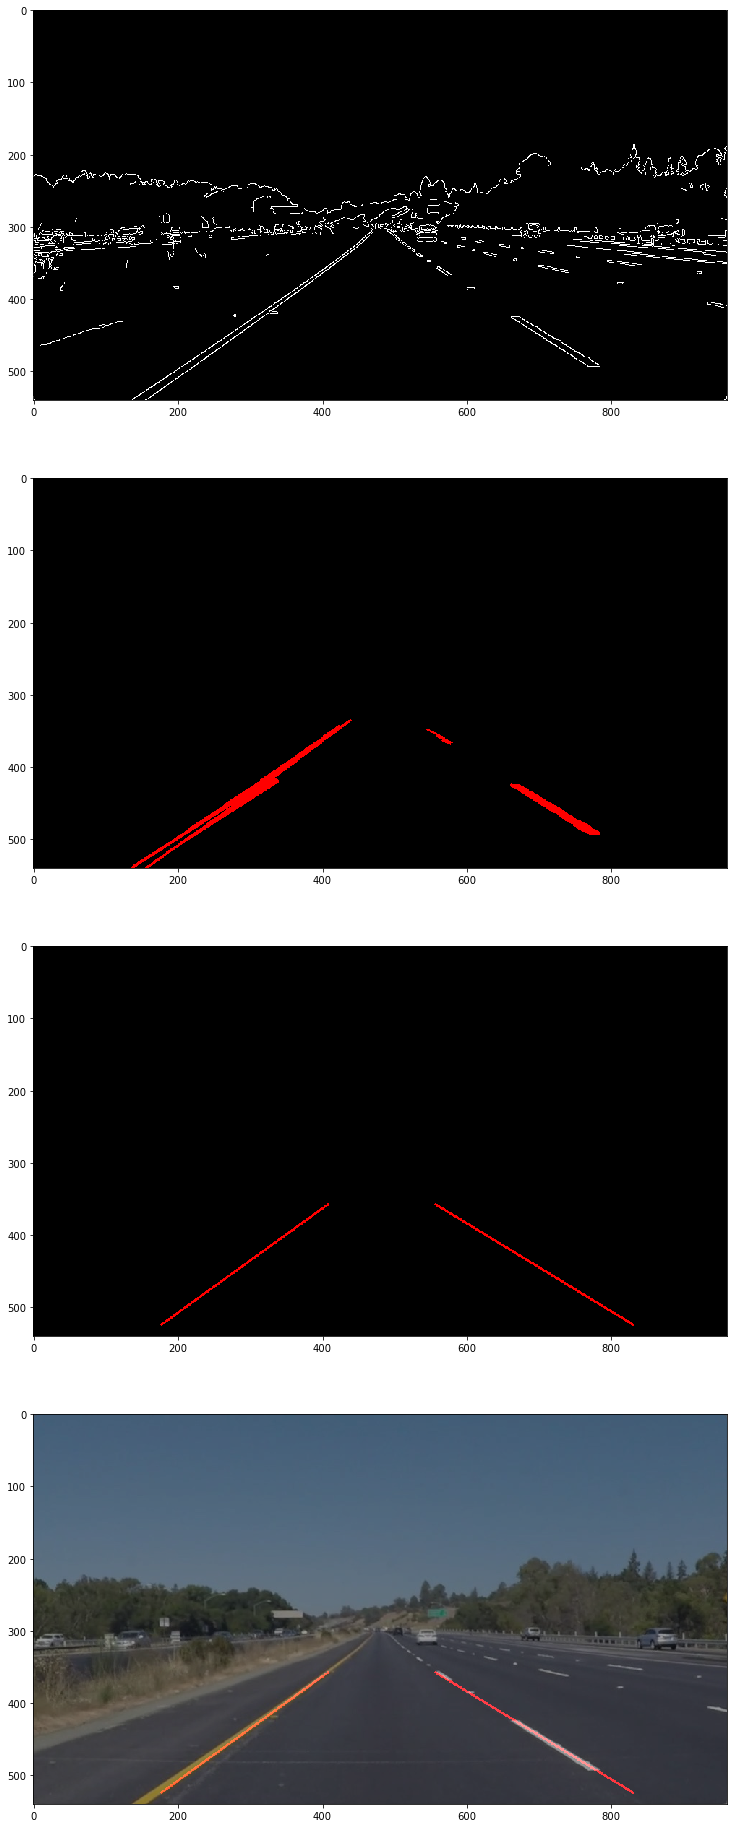

In [152]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(48,33))

im1 = ax1.imshow(cannied, cmap='gray')

im2 = ax2.imshow(drawn_houghed)
#im2 = ax2.imshow(smoothed)

im3 = ax3.imshow(drawn_processed)

im4 = ax4.imshow(result)
#im3 = ax3.imshow(smoothed)

plt.show()

In [87]:
# Put lines in DF
holder = []

for i in houghed_lines:
    holder.append(i[0])
    
lines_df = pd.DataFrame(holder, columns = ['X1','Y1','X2','Y2'])

lines_df

,X1,Y1,X2,Y2
0,140,536,365,391
1,185,518,338,420
2,215,486,382,378
3,265,452,398,366
4,259,466,335,417
5,340,401,426,345
6,315,418,418,351
7,240,479,337,417
8,137,539,341,408
9,710,457,784,491


In [29]:
# Separate lines into LHS & RHS
LHS_lines = lines_df[(lines_df.X1 <= center) & (lines_df.X2 <= center)]
RHS_lines = lines_df[(lines_df.X1 > center) & (lines_df.X2 > center)]

LHS_lines.sort('Y1',axis = 0, ascending = False)[0:5]

,X1,Y1,X2,Y2
8,137,539,341,408
25,156,539,179,524
27,138,538,349,402
0,140,536,365,391
16,167,531,200,509


In [30]:
# For LHS, n start points with highest Y and n endpoints with lowest y and create n*n new lines.' 
n = 5

LHS_high = LHS_lines.sort('Y1', ascending = False)[0:n]
LHS_low = LHS_lines.sort('Y2', ascending = True)[0:n]

RHS_high = RHS_lines.sort('Y2', ascending = False)[0:n]
RHS_low = RHS_lines.sort('Y1', ascending = True)[0:n]

In [31]:
new_LHS_lines = pd.DataFrame()

for i in LHS_high.index:
    for j in LHS_low.index:
        line = [[LHS_high.at[i,'X1'],LHS_high.at[i,'Y1'],LHS_low.at[j,'X2'],LHS_low.at[j,'Y2']]]
        new_LHS_lines = new_LHS_lines.append(line)
        
new_LHS_lines.index = range(0,new_LHS_lines.shape[0])
new_LHS_lines.columns = ['X1','Y1','X2','Y2']
new_LHS_lines

,X1,Y1,X2,Y2
0,137,539,439,335
1,137,539,434,339
2,137,539,423,343
3,137,539,426,345
4,137,539,418,351
5,156,539,439,335
6,156,539,434,339
7,156,539,423,343
8,156,539,426,345
9,156,539,418,351


In [32]:
new_RHS_lines = pd.DataFrame()

for i in RHS_low.index:
    for j in RHS_high.index:
        line = [[RHS_low.at[i,'X1'], RHS_low.at[i,'Y1'], RHS_high.at[j,'X2'], RHS_high.at[j,'Y2']]]
        new_RHS_lines = new_RHS_lines.append(line)
        
new_RHS_lines.index = range(0,new_RHS_lines.shape[0])
new_RHS_lines.columns = ['X1','Y1','X2','Y2']

new_RHS_lines        

,X1,Y1,X2,Y2
0,545,348,772,493
1,545,348,776,493
2,545,348,783,493
3,545,348,780,493
4,545,348,784,491
5,559,356,772,493
6,559,356,776,493
7,559,356,783,493
8,559,356,780,493
9,559,356,784,491


In [33]:
new_RHS_lines['Slope'] = (new_RHS_lines.Y2-new_RHS_lines.Y1)/(new_RHS_lines.X2-new_RHS_lines.X1)
new_LHS_lines['Slope'] = (new_LHS_lines.Y2-new_LHS_lines.Y1)/(new_LHS_lines.X2-new_LHS_lines.X1)
new_RHS_lines['Intercept'] = new_RHS_lines.Y2-new_RHS_lines.Slope*new_RHS_lines.X2
new_LHS_lines['Intercept'] = new_LHS_lines.Y2-new_LHS_lines.Slope*new_LHS_lines.X2

avg_RHS_slope = new_RHS_lines['Slope'].mean()
avg_LHS_slope = new_LHS_lines['Slope'].mean()

avg_RHS_int = new_RHS_lines['Intercept'].mean()
avg_LHS_int = new_LHS_lines['Intercept'].mean()

In [34]:
y_min = min(new_RHS_lines['Y1'].append(new_LHS_lines['Y2']))
y_max = max(new_RHS_lines['Y2'].append(new_LHS_lines['Y1']))



In [35]:
LHS_final_line = [[int((y_max-avg_LHS_int)/avg_LHS_slope), y_max, int((y_min-avg_LHS_int)/avg_LHS_slope), y_min]]
RHS_final_line = [[int((y_min-avg_RHS_int)/avg_RHS_slope), y_min, int((y_max-avg_RHS_int)/avg_RHS_slope), y_max]]

In [36]:
smoothed_lines = [LHS_final_line, RHS_final_line]

In [62]:
all_new_lines = new_RHS_lines[['X1','Y1','X2','Y2']].astype(int).append(new_LHS_lines[['X1','Y1','X2','Y2']].astype(int))

all_new_lines.values.tolist()

[[545, 348, 772, 493],
 [545, 348, 776, 493],
 [545, 348, 783, 493],
 [545, 348, 780, 493],
 [545, 348, 784, 491],
 [559, 356, 772, 493],
 [559, 356, 776, 493],
 [559, 356, 783, 493],
 [559, 356, 780, 493],
 [559, 356, 784, 491],
 [558, 357, 772, 493],
 [558, 357, 776, 493],
 [558, 357, 783, 493],
 [558, 357, 780, 493],
 [558, 357, 784, 491],
 [566, 363, 772, 493],
 [566, 363, 776, 493],
 [566, 363, 783, 493],
 [566, 363, 780, 493],
 [566, 363, 784, 491],
 [669, 424, 772, 493],
 [669, 424, 776, 493],
 [669, 424, 783, 493],
 [669, 424, 780, 493],
 [669, 424, 784, 491],
 [137, 539, 439, 335],
 [137, 539, 434, 339],
 [137, 539, 423, 343],
 [137, 539, 426, 345],
 [137, 539, 418, 351],
 [156, 539, 439, 335],
 [156, 539, 434, 339],
 [156, 539, 423, 343],
 [156, 539, 426, 345],
 [156, 539, 418, 351],
 [138, 538, 439, 335],
 [138, 538, 434, 339],
 [138, 538, 423, 343],
 [138, 538, 426, 345],
 [138, 538, 418, 351],
 [140, 536, 439, 335],
 [140, 536, 434, 339],
 [140, 536, 423, 343],
 [140, 536,

In [77]:
avg_RHS_slope


0.61738145528026511

In [78]:
avg_LHS_slope

-0.69283258351741106